# Velocity Autocorrelation Function #

The velocity autocorrelation function (VAF, $C_v(\tau)$) is a time-dependent correlation function that examines the correlation of a particle's velocity through time. It is a common metric used to study diffusion and other dynamical processes. It is given by:

$$ C_v(\tau) = \lim_{T\to\infty} \int_0^T \langle \vec{v}(t) \cdot \vec{v}(t+\tau) \rangle dt $$

where $\langle \vec{v}(t) \cdot \vec{v}(t+\tau) \rangle = \frac{1}{N_p} \sum_{j=1}^{N_p} \vec{v}_j(t) \cdot \vec{v}_j(t+\tau) $.

The diffusion coefficient, $D$, can be obtained using the Green-Kubo Relation,

$$ D = \frac{1}{d} \int_0^{\infty} C_v(\tau) d\tau $$

where $d$ is the number of dimensions to compute the diffusion coefficient along (in our case, $d=3$).

*Note that the experimentally determined diffusion coefficient of liquid argon at 120K is: $6.17 \times 10^{-5} \; cm^{2} \; sec^{-1}$, from:* 

Jamshid Naghizadeh, Stuart A. Rice. Kinetic Theory of Dense Fluids. X. Measurement and Interpretation of Self‐Diffusion in Liquid Ar, Kr, Xe, and CH4. *J. Chem. Phys.* **1962**, *36*(10): 2710–2720. https://doi.org/10.1063/1.1732357

Going further, the power spection (i.e. the spectral density of velocity) and be obtained by taking the fourier transform of the VAF:

$$ \tilde{C}_v(\omega) = \int_{-\infty}^{\infty} e^{i\omega\tau} C_v(\tau) d\tau $$

### Retrieving Data ###

The data from a Lennard-Jones Fluid simulation (using the code we have been developing) is available on Blackboard. The parameters for this simulation were:

- `n_particles=216`
- `temp=120.0`
- `density=0.0291`
- `time_step=0.001`
- `length_of_equilibration=1000`
- `length_of_simulation=30000`
- `write_freq=1`
- `sigma=3.405`
- `epsilon=0.238`
- `mass=0.03994`
- `file_namestem=""`

This data can be read using the following function:

In [1]:
import numpy as np

def readXYZ(filename, stage="both"):
    '''
    Reads an XYZ file (that was written by OutputWriter)

    Parameters
    ----------
    filename : str
        Name of the file to read
    stage : "equilibration", "production", "both"
        Which stage of the simulation to read. Default is "both"

    Returns
    -------
    times : numpy.ndarray(shape=(N_frames,))
        The times at each timestep (in ps)
    frames : numpy.ndarray(shape=(N_frames, N_atoms, 3))
        The data stored in the file for each frame
    '''
    def _floatcheck(str):
        # Check if string is a float
        return str.replace(".", "").replace("-", "").isnumeric()
    
    with open(filename) as file:
        new_frame = True
        frames, times = [], []
        for i, line in enumerate(file.readlines()):
            lc = line.strip().split() # The line contents as a list without leading and trailing whitespace
            if len(lc) == 1 and lc[0].isnumeric():
                natoms = int(lc[0])
                new_frame = True
            elif len(lc) == 4 and _floatcheck(lc[1]) and new_frame:
                if (stage=="both" or (stage=="equilibration" and lc[3]=="(0)") or (stage=="production" and lc[3]=="(1)")): # Check if this line has the time and is in the right stage
                    frames.append(np.zeros((natoms, 3))) # Create empty array to hold this frames positions
                    curr_atom = 0
                    times.append(float(lc[1]))
                    new_frame = False
                else:
                    continue
            elif len(lc) == 4 and _floatcheck(lc[1]) and _floatcheck(lc[2]) and _floatcheck(lc[3]):
                if not new_frame:
                    frames[-1][curr_atom, :] = list(map(float, lc[1:]))
                    curr_atom += 1
            else:
                print(f"Error: Unrecognized line ({i}) of {filename}: {line}")
                break
    return np.array(times), np.array(frames)

***

In [2]:
from numba import jit, prange, set_num_threads
from tqdm.notebook import tqdm

@jit(nopython=True, parallel=True)
def calc_vaf_tau(velocities, tau):
    ''' 
    A function for computing the vacf value for a given tau

    Parameters
    ----------
    trajectory : numpy.ndarray(shape=(n_frames, n_particles, 3))
        The velocities of the particles
    tau : int
        The change in time, in number of steps
    
    Returns
    -------
    vaf : float
        The value of the vaf for the given tau
    '''
    vaf = 0 
    for t in prange(velocities.shape[0]-tau): # Iterate through all possible reference frames for the given tau
        vaf += np.sum(velocities[t]*velocities[t+tau]) / velocities.shape[1] # add dot product of v(t) and v(t+tau) averaged over all atoms
    vaf = vaf / (velocities.shape[0]-tau) # average over all reference frames
    return vaf

def calc_vaf(trajectory, times):
    ''' 
    Calculate the velocity autocorrelation function

    Parameters
    ----------
    trajectory : numpy.ndarray(shape=(n_frames, n_particles, 3))
        The velocities of the particles 
    times : numpy.ndarray(shape=(n_frames))
        The times of each frame, in ps

    Returns
    -------
    vaf : np.ndarray(shape=(np.floor(n_frames/2)))
        The velocity autocorrelation function
    taus : np.ndarray(shape=(np.floor(n_frames/2)))
        The time intervals corresponding to each VAF value in ps
    '''
    maxtau = int(np.floor(trajectory.shape[0]/2)) # tau_max = floor(num_frames/2)
    vaf = np.zeros(maxtau)
    for tau in tqdm(range(0, maxtau)): # calculate vaf for all taus up to maxtau
        vaf[tau] = calc_vaf_tau(trajectory, tau) # calculate value of vaf for current tau
    taus = times[:maxtau]-times[0] # calculate value of tau in ps

    return vaf, taus


# set_num_threads(6) # Comment out this line if you don't know how many processors your computer has, or use it to control how many processors to use.
times, trajectory = readXYZ(f"velocities.xyz", stage="production")
vaf, taus = calc_vaf(trajectory, times)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [3]:
def calc_vaf_diffcoef(vaf, taus):
    '''
    Calculate diffusion coefficient from the vaf

    Parameters
    ----------
    vaf : np.ndarray(shape=(np.floor(n_frames/2)))
        The velocity autocorrelation function
    taus : np.ndarray(shape=(np.floor(n_frames/2)))
        The time intervals corresponding to each VAF value, in ps
    
    Returns
    -------
    D : float
        Diffusion coefficient in cm^2/sec
    '''
    integral = np.trapz(vaf, taus) # Integral of VAF
    
    # Divide by d
    D = integral/3
    
    # Now convert to cm^2/sec
    D = D/10000

    return D

def calc_correlation_time(vaf, taus):
    '''
    Calculate the correlation time from the VAF

    Parameters
    ----------
    vaf : np.ndarray(shape=(np.floor(n_frames/2)))
        The velocity autocorrelation function
    taus : np.ndarray(shape=(np.floor(n_frames/2)))
        The time intervals corresponding to each VAF value, in ps
    
    Returns
    -------
    tau_c : float
        The correlation time, in ps
    '''
    tau_c = np.trapz(vaf/vaf[0], taus) #integral of normalized VAF

    return tau_c

from scipy.fft import rfft, rfftfreq
from scipy.signal import get_window
def power_spectrum(vaf, timestep):
    '''
    Calculate the correlation time from the VAF

    Parameters
    ----------
    vaf : np.ndarray(shape=(np.floor(n_frames/2)))
        The velocity autocorrelation function
    timestep : float
        The timestep, in ps

    Returns
    -------
    spectrum : np.ndarray
        The velocity spectral density
    frequencies : np.ndarray
        The frequencies corresponding to the spectrum values
    '''
    # Use a window function to reduce spectral leakage
    window_function = get_window("blackman", vaf.size)

    # Compute spectrum with Fast Fourier Transform
    spectrum = np.abs(rfft(vaf*window_function, norm="ortho"))

    # Calculate frequencies
    frequencies = rfftfreq(vaf.size, timestep)

    # Convert to wavenumbers
    frequencies = (frequencies * 10**12) / 29979245800 # hz/c = cm^{-1}

    return spectrum, frequencies


In [4]:
D_vaf = calc_vaf_diffcoef(vaf[:1500], taus[:1500])
tau_c = calc_correlation_time(vaf[:1500], taus[:1500])
spectrum, frequencies = power_spectrum(vaf[:5000], times[1]-times[0])

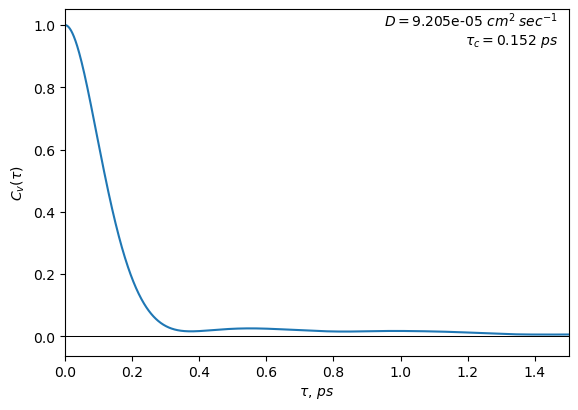

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6.5, 4.5))
ax.axhline(0, color="k", linewidth=0.75)
ax.plot(taus, vaf/vaf[0], color="tab:blue")
ax.set_ylabel(r"$C_v(\tau)$")
ax.set_xlabel(r"$\tau$, $ps$")
ax.annotate(r'$D = $'+f'{D_vaf:.3e} '+r'$cm^2\; sec^{-1}$'+'\n'+r'$\tau_c = $'+f'{tau_c:.3f} '+r'$ps$', (0.98,0.9), xycoords='axes fraction', ha='right')
ax.set_xlim(0, 1.5)

plt.show()

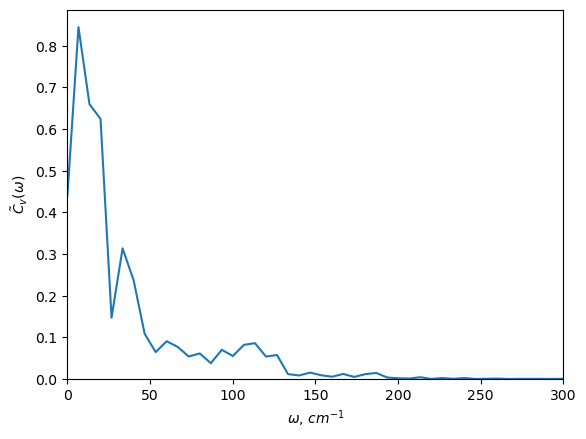

In [6]:
fig, ax = plt.subplots()
ax.plot(frequencies, spectrum, color="tab:blue")
ax.set_ylabel(r"$\tilde{C}_v(\omega)$")
ax.set_xlabel(r"$\omega$, $cm^{-1}$")
ax.set_xlim(0,300)
ax.set_ylim(0)
plt.show()